In [2]:
import time
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping

import matplotlib.pyplot as plt

from common import *

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

# prevent tensorflow from allocating the entire GPU memory at once
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

numpy ver.: 1.13.1
pandas ver.: 0.19.0
tensorflow ver.: 1.0.0
keras ver.: 2.0.8


## Functions

### Functions for generate data

In [3]:
def build_model(input_timesteps, output_timesteps):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, 30, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.2, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.1, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, 30, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.1, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(Dense(units=1, name = 'dense_2'))

    optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
    model.compile(loss = "mse", optimizer = optimizer)
    return model

## Load data

In [4]:
data = prep_data('../data/4A_1_201701_201708.csv')
data.shape

(1769626, 11)

In [5]:
data = data[(1 <= data['LineDirectionLinkOrder']) & (data['LineDirectionLinkOrder'] <= 30)]
assert len(data['LinkRef'].unique()) == 30
n = len(data)
print(n)

1288980


### Mean center

In [6]:
(means, scales, low, upr) = fit_scale(data, smooth = 7)
assert means.shape[0] == 4 * 24 * 7
assert len(scales) == 30
assert len(low) == 30
assert len(upr) == 30
(means.shape, len(scales), len(low), len(upr))

((672, 30), 30, 30, 30)

In [7]:
ix, ts, removed_mean, removed_scale, w, ks = transform(data, means, scales, low, upr)
(ix.shape, ts.shape, removed_mean.shape, removed_scale.shape, w.shape)

((23327,), (23327, 30), (23327, 30), (23327, 30), (23327, 30))

## Look at data

### Look at means (reference data)

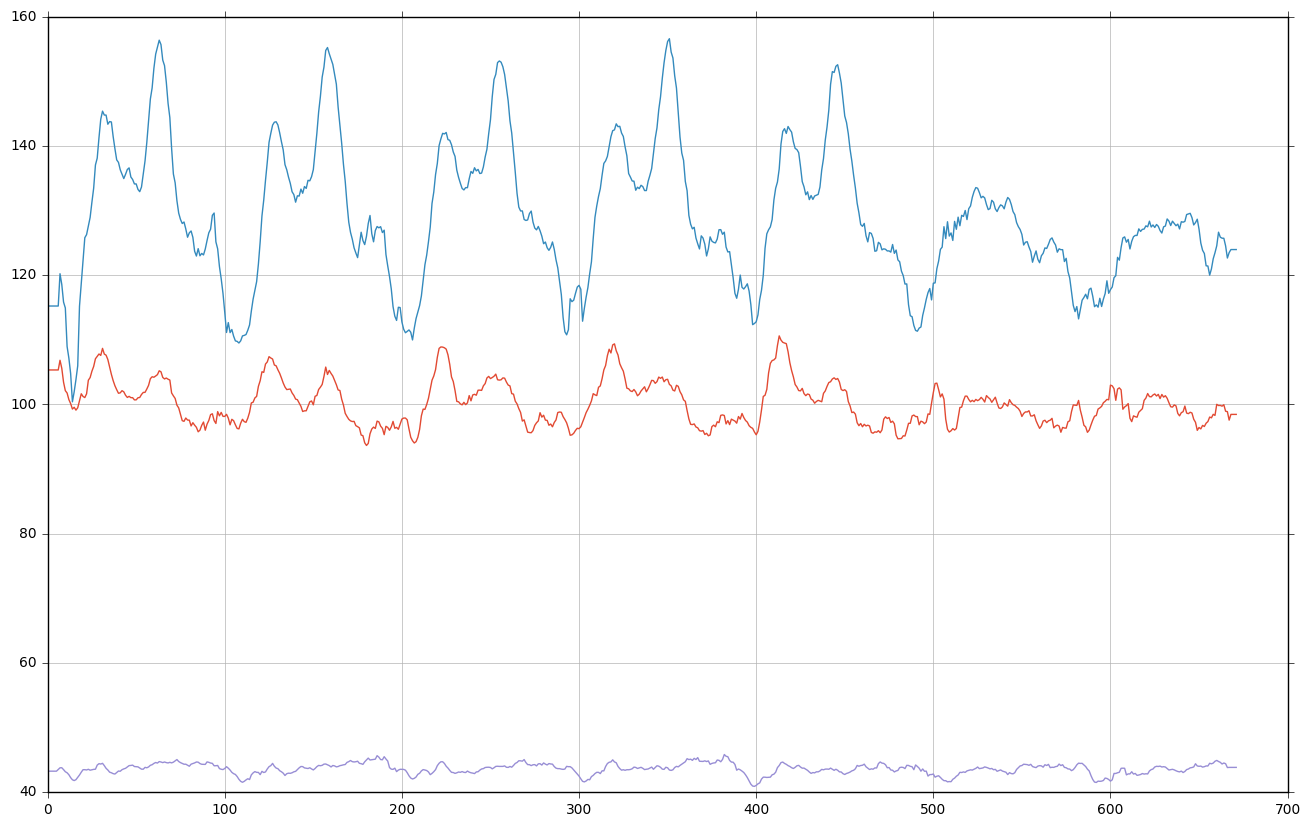

In [8]:
plt.plot(means.iloc[:,6:9].values)
#plt.legend(means_df.columns, loc='upper right')
plt.show()

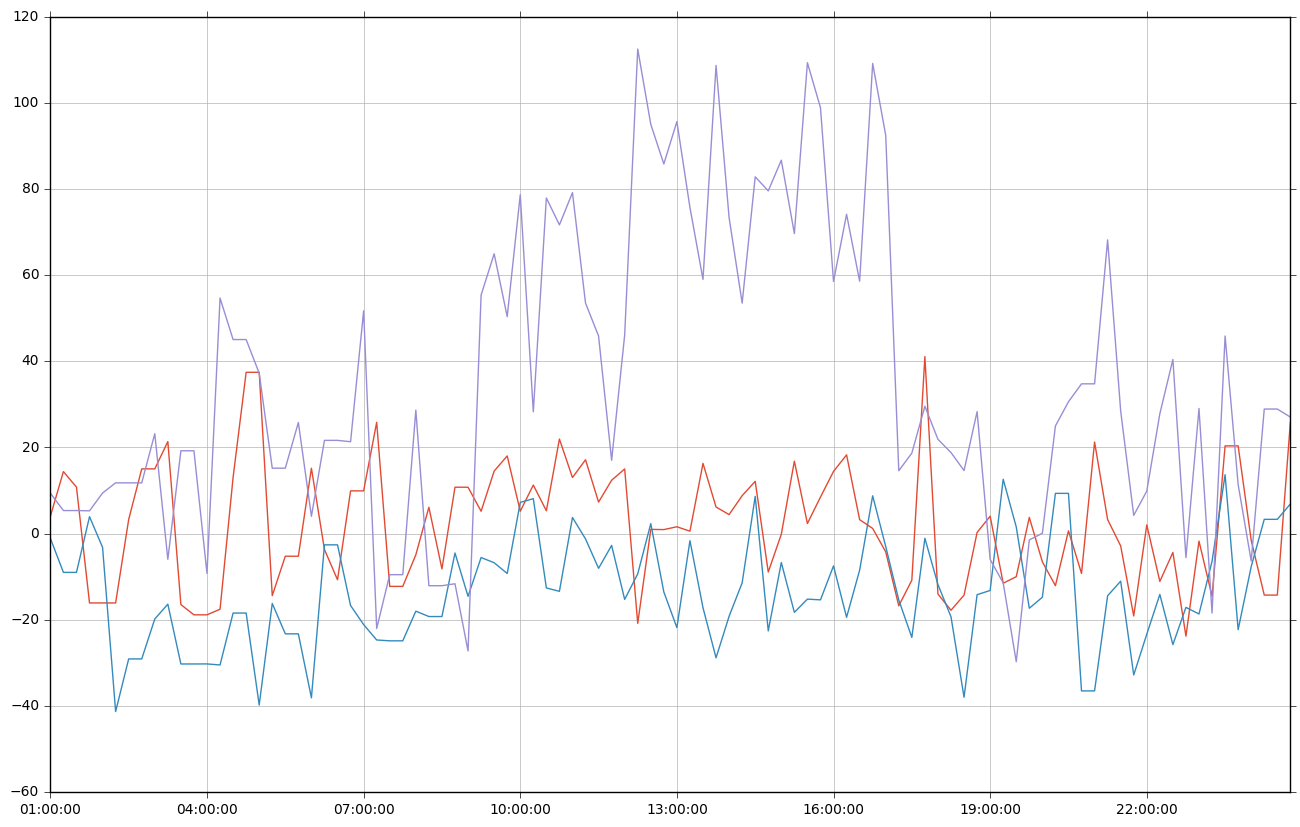

In [9]:
plt.plot(ix[6*4*24:7*4*24], ts[6*4*24:7*4*24,5:8])
plt.show()

In [11]:
lags = 4 * 8
preds = 3
build_model(lags, preds).summary()

InternalError: Dst tensor is not initialized.
	 [[Node: conv_lstm_1_1/recurrent_kernel/initial_value = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [10,1,64,256] values: [[[-0.010348318 0.0044581736 -0.04155691]]]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'conv_lstm_1_1/recurrent_kernel/initial_value', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-1f54118a2677>", line 3, in <module>
    build_model(lags, preds).summary()
  File "<ipython-input-3-d5dcb6050451>", line 7, in build_model
    return_sequences = True))
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 475, in add
    output_tensor = layer(self.outputs[0])
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/recurrent.py", line 268, in __call__
    return super(Recurrent, self).__call__(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 575, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/convolutional_recurrent.py", line 381, in build
    constraint=self.recurrent_constraint)
  File "/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 399, in add_weight
    constraint=constraint)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 316, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 286, in _init_from_args
    initial_value, name="initial_value", dtype=dtype)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 637, in convert_to_tensor
    as_ref=False)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 702, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/constant_op.py", line 111, in _constant_tensor_conversion_function
    return constant(v, dtype=dtype, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/constant_op.py", line 104, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2334, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Dst tensor is not initialized.
	 [[Node: conv_lstm_1_1/recurrent_kernel/initial_value = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [10,1,64,256] values: [[[-0.010348318 0.0044581736 -0.04155691]]]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


## Train and test

In [ ]:
X = np.stack([np.roll(ts, i, axis = 0) for i in range(lags, 0, -1)], axis = 1)[lags:-preds,:,:,np.newaxis,np.newaxis]
y = np.stack([np.roll(ts, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:,np.newaxis,np.newaxis]
ix_y = ix[lags:-preds]
y_mean = np.stack([np.roll(removed_mean, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:]
y_scale = np.stack([np.roll(removed_scale, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:]
w_y = np.stack([np.roll(w, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:]

(X.shape, y.shape, ix_y.shape, y_mean.shape, y_scale.shape, w_y.shape)

In [ ]:
global_start_time = time.time()
csv_logger = CSVLogger('logs/convlstm_training.log')
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

bootstrap_size = int(len(y)*0.75)
n_test = int(len(y)*0.05)
n_windows = 5

hist = []
windows = []
for i in range(bootstrap_size, min(bootstrap_size + n_windows * n_test, len(y)), n_test):
    windows.append((i, i + n_test))
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Current window: " + str(i) + " - " + str(i+n_test))
    
    X_train = X[:i,]
    y_train = y[:i,]
    
    X_test = X[i:i+n_test,]
    y_test = y[i:i+n_test,]    
    w_test = w_y[i:i+n_test,]
    
    model = build_model(lags, preds)
    
    # Train
    history = model.fit(X_train, y_train,
                        batch_size = 512, epochs = 30,
                        shuffle = False, validation_data = (X_test, y_test),
                        verbose = 0, callbacks = [csv_logger, early_stopping])
    hist.append(history)
    model.save('models/convlstm_3x15min_10-5-10-5_' + str(i) + '.h5') 
    
    y_true = y_test.squeeze() * y_scale[i:i+n_test,] + y_mean[i:i+n_test,]
    y_naive = y_mean[i:i+n_test,]
    y_pred = model.predict(X_test).squeeze() * y_scale[i:i+n_test,] + y_mean[i:i+n_test,]
        
    y_true_total = np.sum(y_true * w_test, axis = 2).squeeze()
    y_naive_total = np.sum(y_naive * w_test, axis = 2).squeeze()
    y_pred_total = np.sum(y_pred * w_test, axis = 2).squeeze()

    for t in range(preds):
        mask = y_true_total[:,t] > 0
        y_true_total_t = y_true_total[mask, t] / 60
        y_naive_total_t = y_naive_total[mask, t] / 60
        y_pred_total_t = y_pred_total[mask, t] / 60  

        error_naive_total_t = (y_naive_total_t - y_true_total_t)
        error_lstm_total_t = (y_pred_total_t - y_true_total_t)

        mae_ha = np.mean(np.abs(error_naive_total_t))
        rmse_ha = np.sqrt(np.mean((error_naive_total_t)**2))
        mape_ha = np.mean(np.abs(error_naive_total_t) / y_true_total_t) * 100

        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " - t + %d - HA   - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_ha, rmse_ha, mape_ha))

        mae_lstm = np.mean(np.abs(error_lstm_total_t))
        rmse_lstm = np.sqrt(np.mean((error_lstm_total_t)**2))
        mape_lstm = np.mean(np.abs(error_lstm_total_t) / y_true_total_t) * 100

        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " - t + %d - LSTM - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm, rmse_lstm, mape_lstm))
        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " - t + %d - *    - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm - mae_ha, rmse_lstm - rmse_ha, mape_lstm - mape_ha))

print('Training duration (s) : ', time.time() - global_start_time)    

In [ ]:
for history in hist:
    plt.plot(history.history['loss'])
for history in hist:
    plt.plot(history.history['val_loss'], linestyle = '--')
    
fig = plt.figure(figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.plot(np.array(hist[-2].history['loss']) / 60)
ax.plot(np.array(hist[-2].history['val_loss']) / 60, linestyle = '--')
plt.ylabel('loss (min)', fontsize = 14)
plt.xlabel('epoch', fontsize = 14)
plt.legend(['train', 'test'], loc='upper right')
#plt.show()
fig.savefig('conv_lstm_model_loss.pdf')
#fig.close()

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

In [ ]:
plt.plot(y_test[:200,0,:1,0].squeeze(), color = 'b', linestyle = '--')
plt.plot(y_pred[:200,0,:1,0].squeeze(), color = 'r', linestyle = '--')



#plt.plot(y_test[:20,10,0], color = 'r', linestyle = '-.')

plt.show()